# Fraud Detection

Classical layers using Keras dense and quantum layers using Pennylane

Dependencies: keras-nightly==2.5.0.dev2021032900 PennyLane==0.17.0 StrawberryFields==0.18.0 tensorflow-2.4.0-cp38-cp38-macosx_10_9_x86_64.whl

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import pennylane as qml

import matplotlib.pyplot as plt

In [2]:
# ===================================================================================
#                       Data Preparation Function
# ===================================================================================

# 1,968 samples 
data = pd.read_csv('ccfraud_10_features_1968.csv')

def data_prep(data_frame):
    
    if len(data_frame.columns) == 12:
        data = data_frame.iloc[:, 1:]   # weird glitch with additional column. Drop the first column
    shuffled = data.sample(frac=1)      # shuffle data
    features = shuffled.iloc[:, :-1]    # select only the features by dropping the last column
    labels = shuffled.iloc[:, -1]       # select only the labels by selecting the last column
    
    # convert data to numpy array to use train and test split using scikitlearn
    features_np = features.to_numpy(dtype=np.float32)
    labels_np = labels.to_numpy(dtype=np.int32)
    
    # split data into train and test, features and labels
    X_train, X_test, y_train, y_test = train_test_split(features_np, labels_np, test_size=0.2, random_state=42)
        
    return X_train, y_train, X_test, y_test

def one_hot(labels):  
    
    depth = 2
    indices = labels.astype(np.int32)    
    one_hot_labels = np.eye(depth)[indices].astype(np.float32) 
    
    return one_hot_labels

# one-hot encoded labels, each label of length cutoff dimension**2
X_train, Y_train, X_test, Y_test = data_prep(data)
y_train, y_test = one_hot(Y_train), one_hot(Y_test)

# convert them into tensorflow tensors
X_train = tf.convert_to_tensor(X_train)
y_train = tf.convert_to_tensor(y_train)
X_test = tf.convert_to_tensor(X_test)
y_test = tf.convert_to_tensor(y_test)

In [3]:
# ===================================================================================
#                                Classical Layers
# ===================================================================================
# Define classical layers using Keras Sequential

keras.backend.set_floatx('float32')

hidden = layers.Dense(10, activation ="elu")
out = layers.Dense(14, activation ="elu")                    

In [6]:
# ===================================================================================
#                                Quantum State Encoding
# ===================================================================================

# quantum state preparation converting the classical output to quantum 
# init_layer(classical)|0> = |quantum>

def init_layer(x):
    qml.Squeezing(x[0], x[1], wires=0)
    qml.Squeezing(x[2], x[3], wires=1)
    qml.Beamsplitter(x[4], x[5], wires=[0,1])
    qml.Rotation(x[6], wires=0)
    qml.Rotation(x[7], wires=1)
    qml.Displacement(x[8], x[9], wires=0)
    qml.Displacement(x[10], x[11], wires=1)
    qml.Kerr(x[12], wires=0)
    qml.Kerr(x[13], wires=1)

In [7]:
# ===================================================================================
#                                    Quantum Layer
# ===================================================================================

# initialize parameters for the quantum layers: number of layers x number of parameters needed for all the gates

def init_weights(layers, modes, active_sd=0.0001, passive_sd=0.1):
    
    M = 2 + 1 + 1  # Number of interferometer parameters: beamsplitter + 2 rotations

    int1_weights = tf.random.normal(shape=[layers, M], stddev=passive_sd)
    s_weights = tf.random.normal(shape=[layers, modes], stddev=active_sd)
    int2_weights = tf.random.normal(shape=[layers, M], stddev=passive_sd)
    dr_weights = tf.random.normal(shape=[layers, modes], stddev=active_sd)
    k_weights = tf.random.normal(shape=[layers, modes], stddev=active_sd)

    weights = tf.concat([int1_weights, s_weights, int2_weights, dr_weights, k_weights], axis=1)
    weights = tf.Variable(weights)

    return weights

# quantum layer for iteration

def layer(v):
    qml.Beamsplitter(v[0], v[1], wires=[0,1])
    qml.Rotation(v[2], wires=0)
    qml.Rotation(v[3], wires=1)
    qml.Squeezing(v[4], 0.0, wires=0)
    qml.Squeezing(v[5], 0.0, wires=1)
    qml.Beamsplitter(v[6], v[7], wires=[0,1])
    qml.Rotation(v[8], wires=0)
    qml.Rotation(v[9], wires=1)
    qml.Displacement(v[10], 0.0, wires=0)
    qml.Displacement(v[11], 0.0, wires=1)
    qml.Kerr(v[12], wires=0)
    qml.Kerr(v[13], wires=1)



In [8]:
# ===================================================================================
#                                    Quantum Circuit
# ===================================================================================

num_modes = 2
num_basis = 2

# select a devide 
dev = qml.device("strawberryfields.fock", wires=num_modes, cutoff_dim=num_basis) 

@qml.qnode(dev, interface="tf")
def quantum_nn(inputs, var):
    # Encode input x into quantum state
    init_layer(inputs)

    # iterative quantum layers
    for v in var:
        layer(v)
    
    return [qml.expval(qml.X(0)), qml.expval(qml.X(1))]

In [9]:
# ===================================================================================
#                                    Hybrid Model
# ===================================================================================

"""
Add the quantum layer to the classical to create a hybrid model
    1. initialize weights for quantum layers
    2. create a dictionary of weight shape to pass as one of the variables to covert to keras layer
    3. convert the quantum layer to a Keras layer
    4. add to the classical sequential model
"""
num_layers = 4

def hybrid_model(num_layers, num_modes):
    
    weigths = init_weights(num_layers, num_modes)
    shape_tup = weigths.shape
    weight_shapes = {'var': shape_tup}
    qlayer = qml.qnn.KerasLayer(quantum_nn, weight_shapes, output_dim=4)
    hybrid_model = tf.keras.Sequential([hidden, hidden, out, qlayer])
    
    return hybrid_model

model = hybrid_model(num_layers, num_modes)

In [10]:
# ===================================================================================
#                                     Training
# ===================================================================================

opt = keras.optimizers.Adam(learning_rate=0.01)

model.compile(opt, loss = 'MSE', metrics = ['accuracy'])

history = model.fit(X_train, 
                    y_train,
                    epochs = 40,
                    batch_size = 190,
                    shuffle = True,
                    validation_data=(X_test, y_test))

Epoch 1/40
9/9 [==============================] - 885s 97s/step - loss: 0.6641 - accuracy: 0.1976 - val_loss: 0.5068 - val_accuracy: 0.3223
Epoch 2/40
9/9 [==============================] - 890s 98s/step - loss: 0.5035 - accuracy: 0.2808 - val_loss: 0.4918 - val_accuracy: 0.3223
Epoch 3/40
9/9 [==============================] - 916s 101s/step - loss: 0.4921 - accuracy: 0.2901 - val_loss: 0.4874 - val_accuracy: 0.3807
Epoch 4/40
9/9 [==============================] - 925s 102s/step - loss: 0.4890 - accuracy: 0.3398 - val_loss: 0.4793 - val_accuracy: 0.3706
Epoch 5/40
9/9 [==============================] - 719s 76s/step - loss: 0.4765 - accuracy: 0.3445 - val_loss: 0.4551 - val_accuracy: 0.4340
Epoch 6/40
9/9 [==============================] - 701s 78s/step - loss: 0.4428 - accuracy: 0.4289 - val_loss: 0.3856 - val_accuracy: 0.6675
Epoch 7/40
9/9 [==============================] - 1151s 132s/step - loss: 0.3664 - accuracy: 0.6654 - val_loss: 0.2826 - val_accuracy: 0.7766
Epoch 8/40
9/9 [

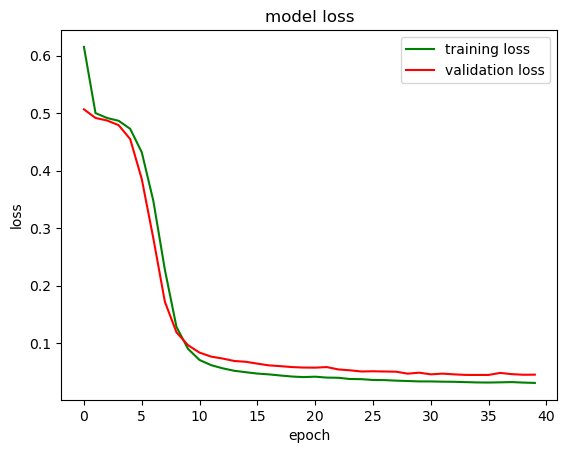

In [16]:
# ===================================================================================
#                                  Loss History Plot
# ===================================================================================

plt.title('model loss')
plt.plot(history.history['loss'], '-g', label = 'training loss')
plt.plot(history.history['val_loss'], '-r', label = 'validation loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(loc='upper right')
plt.show()

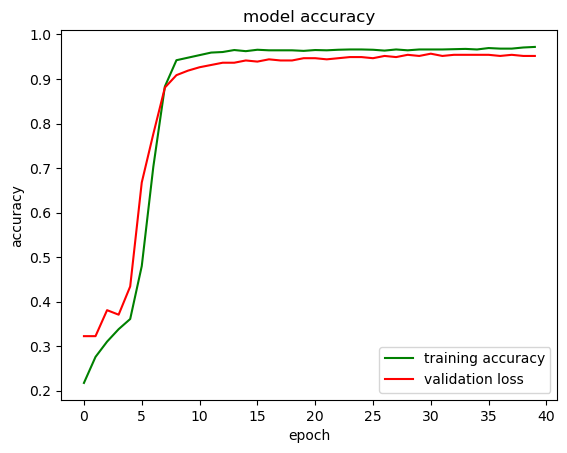

In [17]:
# ===================================================================================
#                                Accuracy History Plot
# ===================================================================================

plt.title('model accuracy')
plt.plot(history.history['accuracy'], '-g', label = 'training accuracy')
plt.plot(history.history['val_accuracy'], '-r', label = 'validation loss')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(loc='lower right')
plt.show()